Epoch 1, Loss: 0.5467, Test Loss: 0.5031, Test Accuracy: 0.7486
Epoch 2, Loss: 0.4526, Test Loss: 0.3968, Test Accuracy: 0.8196
Epoch 3, Loss: 0.4035, Test Loss: 0.3864, Test Accuracy: 0.8138
Epoch 4, Loss: 0.3595, Test Loss: 0.5696, Test Accuracy: 0.7620
Epoch 5, Loss: 0.3517, Test Loss: 0.3569, Test Accuracy: 0.8311
Epoch 6, Loss: 0.3299, Test Loss: 0.2900, Test Accuracy: 0.8733
Epoch 7, Loss: 0.3234, Test Loss: 0.3250, Test Accuracy: 0.8541
Epoch 8, Loss: 0.3267, Test Loss: 0.2877, Test Accuracy: 0.8887
Epoch 9, Loss: 0.2930, Test Loss: 0.4979, Test Accuracy: 0.7793
Epoch 10, Loss: 0.2936, Test Loss: 0.6664, Test Accuracy: 0.6967
Epoch 11, Loss: 0.2886, Test Loss: 0.3281, Test Accuracy: 0.8311
Epoch 12, Loss: 0.2629, Test Loss: 0.2770, Test Accuracy: 0.8887
Epoch 13, Loss: 0.2863, Test Loss: 0.2471, Test Accuracy: 0.9021
Epoch 14, Loss: 0.2586, Test Loss: 0.4642, Test Accuracy: 0.7965
Epoch 15, Loss: 0.2404, Test Loss: 0.2515, Test Accuracy: 0.8964
Epoch 16, Loss: 0.2290, Test Loss:

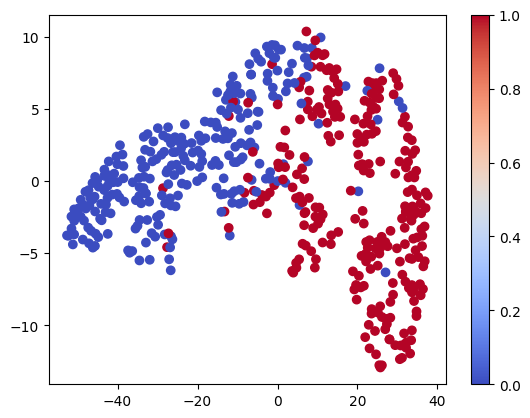

Epoch 1, Loss: 0.2366, Test Loss: 0.1129, Test Accuracy: 0.9559
Epoch 2, Loss: 0.1596, Test Loss: 0.1153, Test Accuracy: 0.9501
Epoch 3, Loss: 0.1849, Test Loss: 0.1047, Test Accuracy: 0.9559
Epoch 4, Loss: 0.1266, Test Loss: 0.1420, Test Accuracy: 0.9405
Epoch 5, Loss: 0.1312, Test Loss: 0.1102, Test Accuracy: 0.9539
Epoch 6, Loss: 0.1209, Test Loss: 0.1156, Test Accuracy: 0.9539
Epoch 7, Loss: 0.0858, Test Loss: 0.1085, Test Accuracy: 0.9520
Epoch 8, Loss: 0.1412, Test Loss: 0.1819, Test Accuracy: 0.9136
Epoch 9, Loss: 0.0974, Test Loss: 0.1051, Test Accuracy: 0.9597
Epoch 10, Loss: 0.0973, Test Loss: 0.0944, Test Accuracy: 0.9616
Epoch 11, Loss: 0.0957, Test Loss: 0.1275, Test Accuracy: 0.9347
Epoch 12, Loss: 0.0813, Test Loss: 0.1020, Test Accuracy: 0.9597
Epoch 13, Loss: 0.1019, Test Loss: 0.1062, Test Accuracy: 0.9559
Epoch 14, Loss: 0.1019, Test Loss: 0.1622, Test Accuracy: 0.9424
Epoch 15, Loss: 0.0952, Test Loss: 0.1750, Test Accuracy: 0.9424
Epoch 16, Loss: 0.0718, Test Loss:

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from sklearn.manifold import TSNE

data_dir = r"C:\Users\User\food_drink"
csv_file = r"C:\Users\User\filtered_photos.csv"

df = pd.read_csv(csv_file, names=["photo", "label"])
df["photo_path"] = data_dir + "/" + df["photo"]
df = df[df["label"] != "label"]

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

class FoodDrinkDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["photo_path"]).convert("RGB")

        if row["label"] == "food":
            label = 0
        else:
            label = 1

        if self.transform:
            image = self.transform(image)

        return image, label

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = FoodDrinkDataset(train_df, transform=train_transform)
test_dataset = FoodDrinkDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AdaptiveAvgPool2d(1)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
writer = SummaryWriter(log_dir="logs/cnn")

def evaluate(model, dataloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss = test_loss / len(test_loader)
    accuracy = correct / total
    return test_loss, accuracy

epochs = 31
start_time_cnn = time.time()

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    writer.add_scalar("Loss/train", train_loss, epoch)
    test_loss, accuracy = evaluate(model, test_loader, criterion)
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("Accuracy/test", accuracy, epoch)
    print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

end_time_cnn = time.time()
print(f"Время обучения: {end_time_cnn - start_time_cnn:.2f} сек")

def get_embeddings(model, loader):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for images, label in loader:
            images = images.to(device)
            output = model.conv_layers(images)
            output = output.view(output.shape[0], -1)
            output = model.fc_layers[0](output)
            embeddings.append(output.cpu().numpy())
            labels.extend(label.numpy())

    return np.vstack(embeddings), np.array(labels)

embeddings, labels = get_embeddings(model, test_loader)

tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(embeddings)
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap="coolwarm")
plt.colorbar()
plt.show()

resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)

resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)
writer_resnet = SummaryWriter(log_dir="logs/resnet")
epochs = 31
start_time_resnet = time.time()

for epoch in range(epochs):
    resnet.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    writer_resnet.add_scalar("Loss/train", train_loss, epoch)
    test_loss, accuracy = evaluate(resnet, test_loader, criterion)
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("Accuracy/test", accuracy, epoch)
    print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

end_time_resnet = time.time()
print(f"Время обучения: {end_time_resnet - start_time_resnet:.2f} сек")

